# Project description

The aim of this project is to visualize the quantum and classical ground state of a small magnetic system with the help of jupyter notebook. The idea of this project comes from my research work, treating the magnetic skyrmions quantum mechanically in a frustrated system with the Hamiltonian 
\\[H=-J_1\sum_{<ij>}\mathbf{S}_i\cdot\mathbf{S}_j+J_2\sum_{\ll ij\gg}\mathbf{S}_i\cdot\mathbf{S}_j-K\sum_{<ij>}S_i^zS_j^z-B\sum_iS_i^z\\]
where $\mathbf{S}_i$ is the spin operator of the ith site, $S_i^z$ specifies the $z-$direction component, $J_1$ is the nearest-neighbour ferromagnetic Heisenberg coupling strength, $J_2$ is the next-nearest-neighbour antiferromagnetic coupling strength, $K$ is the easy-axis anisotropy and $B$ is the external field.

Finding the ground state of the given Hamiltonian with real system will take long computation time, thus in this project, system with small size (around 10 spin sites) is considered. After diagonalizing the Hamiltonian matrix with the `eigh` function from the `numpy.linalg` package, the expectation values of the spin operators $\langle S_i^\alpha\rangle$ is calculated with the ground state. Then the quantum spins can be visualized by plotting the spin expectation values in 3D. The classical ground state, on the other hand, can also be calculated with energy variation method or classical Monte Carlo. The comparison of quantum and classical systems can be used in the teaching of matrix quantum mechanics and electromagnetism.

## Cell description:

First we need to import some packages. `numpy` is generally used and `time` is used to monitor the speed of the diagonalization. `eigs` (and `eigsh`) functions are used to diagonalize sparse (and sparse Hermitian) matrices, using Lanczos algorithm. While `eig` (and `eigh`) functions are used to do full diagonalization. `eigs` and `eigsh` give part of the eigenvalues and save time when the Hamiltonian matrix is big and sparse.

In [49]:
import numpy as np
import math
import time

In [50]:
from scipy.sparse.linalg import eigs, eigsh
from numpy.linalg import eig, eigh

## Cell description:

The `cS` and `cSS` functions below is used to create the matrices corresponding to $S_i^\alpha$ and $S_i^\alpha S_j^\beta$ operators. With the given number of sites $N$, the matrices will have the shape $2^N\times 2^N$

In [51]:
def cS(m,alpha,N):
    'define the 1-spin operator S_m^alpha. The matrix representation is a 2**N-d square matrix.'
    if m-1 in range(N):
        sigma = np.empty([2,2,3], dtype=np.complex_)
        sigma[:,:,0] = np.array([[0,1],[1,0]]) * 0.5
        sigma[:,:,1] = np.array([[0,-1j],[1j,0]]) * 0.5
        sigma[:,:,2] = np.array([[1,0],[0,-1]]) * 0.5
        mat = np.empty([2,2,N], dtype=np.complex_)
        for i in range(N):
            mat[:,:,i] = np.eye(2)
        mat[:,:,m-1] = sigma[:,:,alpha-1]
        S = mat[:,:,0]
        for i in range(1,N):
            S = np.kron(S,mat[:,:,i])
    else:
        S = 0
    return S    

In [52]:
def cSS(m,alpha,n,beta,N):
    'define the 2-spin operator S_m^alpha S_n^beta. The matrix representation is a 2**N-d square matrix.'
    if (m-1 in range(N)) & (n-1 in range(N)):
        sigma = np.empty([2,2,3], dtype=np.complex_)
        sigma[:,:,0] = np.array([[0,1],[1,0]]) * 0.5
        sigma[:,:,1] = np.array([[0,-1j],[1j,0]]) * 0.5
        sigma[:,:,2] = np.array([[1,0],[0,-1]]) * 0.5
        mat = np.empty([2,2,N], dtype=np.complex_)
        for i in range(N):
            mat[:,:,i] = np.eye(2)
        if m == n:
            mat[:,:,m-1] = np.matmul(sigma[:,:,alpha-1],sigma[:,:,beta-1])
        else:
            mat[:,:,m-1] = sigma[:,:,alpha-1]
            mat[:,:,n-1] = sigma[:,:,beta-1]
        S = mat[:,:,0]
        for i in range(1,N):
            S = np.kron(S,mat[:,:,i])
    else:
        S = 0
    return S    

## Cell description:

The `Neighb_Label_rect` function below is used to define the rectangular lattice. For a $dx\times dy=N$ lattice, the sites are labelled as
\\[
\begin{array}{cccc}
 1 & 2 & \cdots & dx\\
 dx+1 & dx+2 & \cdots & 2dx\\
 \vdots & \vdots & \ddots & \vdots\\
 N-dx+1 & N-dx+2 & \cdots & N
\end{array}
\\]
The $(dx+2)$th site, for instance, has 
* 4 nearest neighbours (NN): {$dx+3,dx+1,2dx+2,2$} 
* and 4 next nearest neighbours (NNN): {$2dx+3,2dx+1,3,1$},

while the 2nd site has only 3 NN sites and 2 NNN sites, if the open end boundary condition is considered. The `Neighb_Label_rect` function gives a matrix with 8 rows, corresponding to the labels of 4 NN sites and 4 NNN sites. Parameters *ipdX* and *ipdY* control if the periodic boundary condition if applied along the $x/y$ direction.

In [53]:
def Neighb_Label_rect(dx,dy,ipdX,ipdY):
    '''
    Define the label of the nearest neighbouring (NN) 
    and the next nearest neighbouring (NNN) sites on a rectangle lattice.
    dx * dy defines the number of sites. 
    ipdX ,ipdY defines if the x/y direction has periodic boundary condition.
    '''
    nLabel = np.zeros([8,dx*dy], dtype = int) # the first four rows give the NN label
                                              # in x+ x- y+ y- direction; xpyp xpym ypxm ymxm
    NN = np.array([[1,3],[1,4],[2,3],[2,4]])  # the way of finding NNN
    nLabel[0,0:dx*dy-dy] = np.linspace(1+dy,dx*dy,dx*dy-dy)
    nLabel[1,dy:dx*dy] = np.linspace(1,dx*dy-dy,dx*dy-dy)
    for i in range(1,dx*dy+1):
        if i % dy:
            nLabel[2,i-1] = i+1
        if (i % dy) != 1:
            nLabel[3,i-1] = i-1
    if ipdX:
        nLabel[0,dx*dy-dy:dx*dy] = np.linspace(1,dy,dy)
        nLabel[1,0:dy] = np.linspace(dx*dy-dy+1,dx*dy,dy)
    if ipdY:
        for i in range(1,dx*dy+1):
            if not(i % dy):
                nLabel[2,i-1] = i+1-dy
            if (i % dy) == 1:
                nLabel[3,i-1] = i-1+dy
    for i in range(1,dx*dy+1):
        for j in range(4):
            if nLabel[NN[j,0]-1,i-1]:
                nLabel[j+4,i-1]=nLabel[NN[j,1]-1,nLabel[NN[j,0]-1,i-1]-1]
    
    return nLabel

## Cell description:

For hexgonal lattice, the neighbouring sites can be got with similar ideas. One site can have at most 6 NN and 6 NNN.

In [54]:
def Neighb_Label_hex(nl):
    '''
    Define the label of the nearest neighbouring (NN) 
    and the next nearest neighbouring (NNN) sites on a hexgonal lattice with open boundary condition.
    nl in range(2,5) is the number of layers. nl * 6 +1 defines the number of sites. 
    '''
    N = 6*nl+1
    nLabel = np.zeros([12,N], dtype = int) # the first 6 rows give the NN label
                                           # the second 6 rows give the NNN label
    nCoord = Site_Coord_hex(nl)
    nn_vector = np.array([[1,0],[0,1],[-1,1]])
    nnn_vector = np.array([[1,1],[-1,2],[-2,1]])
    
    for i in range(N):
        for j in range(3):
            temp = nCoord[i,:] + nn_vector[j,:]                 # move from site i to its NN i'
            if np.equal(nCoord,temp).all(axis=1).any():         # check if i' is in the lattice 
                nLabel[j,i] = np.where((nCoord == temp).all(axis=1))[0][0] + 1
            temp = nCoord[i,:] - nn_vector[j,:]
            if np.equal(nCoord,temp).all(axis=1).any():
                nLabel[j+3,i] = np.where((nCoord == temp).all(axis=1))[0][0] + 1
            temp2 = nCoord[i,:] + nnn_vector[j,:]                 # move from site i to its NN i'
            if np.equal(nCoord,temp2).all(axis=1).any():         # check if i' is in the lattice 
                nLabel[j+6,i] = np.where((nCoord == temp2).all(axis=1))[0][0] + 1
            temp2 = nCoord[i,:] - nnn_vector[j,:]
            if np.equal(nCoord,temp2).all(axis=1).any():
                nLabel[j+9,i] = np.where((nCoord == temp2).all(axis=1))[0][0] + 1
    return nLabel

## Cell description

The following two functions are used to give the coordinates of the lattice sites, which can be used in the visualization.

In [55]:
def Site_Coord_rec(dx,dy):
    '''
    Define the coordinates of the sites on a rectangular lattice.
    N = dx * dy defines the number of sites. 
    The basis vectors are e1 = [1, 0], e2 = [0, 1]
    site 1 is put on the origin
    '''
    N = dx * dy
    nCoord = np.zeros([N,2])
    # center 
    cen_Coord = np.array([0,0])
    cen = (1.0+N)/2
    cx = (1.0+dx)/2
    cy = (1.0+dy)/2
    e1=np.array([1,0])
    e2=np.array([0,1])
    
    for i in range(0,N):
        ix=math.floor(i/dy)+1
        iy=np.mod(i,dy)+1
        nCoord[i,:]=e1*(iy-cy)+e2*(ix-cx)
    
    return nCoord

In [56]:
def Site_Coord_hex(nl):
    '''
    Define the coordinates of the sites on a hexgonal lattice with open boundary condition.
    nl in range(2,5) is the number of layers. N = nl * 6 +1 defines the number of sites. 
    The basis vectors are e1 = [0, 1], e2 = [sqrt 3 /2, 1/2]
    site 1 is put on the origin
    '''
    N = nl * 6 + 1
    nCoord = np.zeros([N,2])
    # center site nCoord[0,:]=ap.array([0,0])
    
    # first layer, distance from center = 1
    nCoord[1:7,:] = np.array([[i,j] for i in range(-1,2) for j in range(-1,2) if i-j])
    
    # second layer, distance from center = sqrt 3
    if nl > 1:
        nCoord[7:13,:] = np.array([[i,j] for i in [1,-1,2,-2] for j in [1,-1,2,-2] if i*j in [1,-2]])
    
    # third layer distance from center = 2
    if nl > 2:
        nCoord[13:19,:] = 2 * nCoord[1:7,:]
    
    return nCoord

### Diagonalization

The Hamiltonian matrix is input from collecting all the effective interactions. The diagonalization of the Hamiltonian matrix can be done with 
1. [scipy.sparse.linalg.eigsh](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.eigsh.html)
2. [numpy.linalg.eigh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html#numpy.linalg.eigh)

In [57]:
time_start = time.process_time()

lat = 'hex'
nx = 3
ny = 3    
nl = 1

if lat == 'rect':
    Ns = nx * ny
    n_nei = 4    # number of NN on the center site
    nb = Neighb_Label_rect(nx,ny,0,0)

if lat == 'hex':
    Ns = 6 * nl + 1
    n_nei = 6
    nb = Neighb_Label_hex(nl)

J  = 1.
J2 = -0.8
h  = 0.1
ani = 0.05
Hmat = np.zeros([2**Ns,2**Ns], dtype=np.complex64)

for i in range(1,Ns+1):
    for j in range(n_nei):
        for alpha in range(1,4):
            if J != 0:                                            # NN
                Hmat -= cSS(i,alpha,nb[j,i-1],alpha,Ns) * J
            if J2 != 0:                                           # NNN
                Hmat -= cSS(i,alpha,nb[j+n_nei,i-1],alpha,Ns) * J2
        if ani != 0:                                              # anisotropy along z-direction
            Hmat -= cSS(i,3,nb[j,i-1],3,Ns) * ani
    if h != 0:                                                    # external field
        Hmat -= cS(i,3,Ns) * h    

#valsh, vecsh = eigsh(np.matrix(Hmat),k = 2, which = 'SA')          # diagonalization with Lanczos
vals, vecs = eigh(Hmat)

print("Time used: %.2f" %(time.process_time()-time_start))


Time used: 0.75


### Calculation of the quantum ground state expectation values

With the quantum ground state $|0\rangle$, the expectation values can be calculated from 
\\[\langle S_i^\alpha\rangle=\langle 0|S_i^\alpha|0\rangle\\]

In [58]:
gs = vecs[:,0]
spEx = np.empty([3,Ns])
for i in range(1,Ns+1):
    for alpha in range(1,4):
        spEx[alpha-1,i-1] = np.matmul(gs.T,np.dot(cS(i,alpha,Ns),gs)).real
        if abs(spEx[alpha-1,i-1]) < 1e-6:
            spEx[alpha-1,i-1]=0

In [59]:
spEx

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.49997981, 0.26124151, 0.11009819, 0.12867043, 0.12867043,
        0.11009818, 0.26124151]])

The differences between full diagonalization and Lanczos algorithm can be compared.

In [60]:
valsh, vecsh = eigsh(np.matrix(Hmat),k = 2, which = 'SA')

vals, vecs = eigh(np.matrix(Hmat))

print(valsh[0])
print(vals[0])

-4.698662
-4.6986413


## Classical spins

On the other hand, classical spin model can also be investigated. The `init_spin_rect` function is used to initialize the classical spins on a rectangular lattice. The classical spins have magitude $|S|=1$. The `make_en` function gives the energy of a certain spin configuration under classical interactions, which can be used in the later variation method or classical Monte Carlo calculations.

In [61]:
def init_spin_rect(dx,dy):
    '''
    Initialize the classical spins on a dx * dy rectangle lattice with classical spin |S| = 1.
    The orientations of the spins are randomly distributed.
    '''
    N = dx * dy
    spin0 = np.random.rand(3,N) * 2 -1
    norm = (spin0 * spin0).sum(0)**0.5
    spin0 /= norm
    return spin0

In [62]:
def make_en(spin,neib,cp):
    '''calculate the energy of a given classical configuration (defined with spins and neighbouring labels)
    under coupling interactions (J, J2, h, ani)'''
    J = cp[0]
    J2 = cp[1]
    h = cp[2]
    ani = cp[3]
    en = 0
    for i in range(spin.shape[1]):
        for j in range(4):
            for alpha in range(3):
                if J:
                    en -= J * spin[alpha,i] * spin[alpha,neib[j,i]-1]
                if J2:
                    en -= J2 * spin[alpha,i] * spin[alpha+4,neib[j,i]-1]
            if ani:
                en -= ani * spin[2,i] * spin[2,neib[j,i]-1]
        if h:
            en -= h * spin[2,i]
    return en

## Visualization

To plot the classical or quantum spins, packages `matplotlib.pyplot` and `Axes3D` are imported. With the spin values and the coordinates of the lattice sites, the spin texture can be visualized.

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.cm as cm
from matplotlib.colors import Normalize

### The cell below shows a random initial classical spins on a $3\times3$ square lattice.

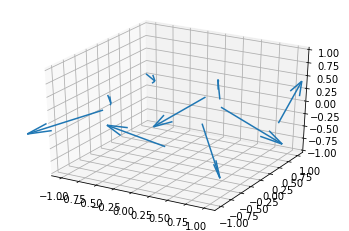

In [66]:
%matplotlib inline

u,v,w = init_spin_rect(3,3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = Site_Coord_rec(3,3)[:,0]
Y = Site_Coord_rec(3,3)[:,1]


ax.quiver(X, Y, np.zeros([1,9]),u, v, w,pivot='middle')
ax.set_zlim(-1,1)

plt.show()

### The cell below plots the ground states of quantum spins on a 7-site hexgonal lattice

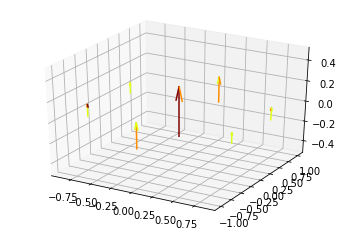

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X = Site_Coord_hex(1)[:,1]*np.sqrt(3)/2
Y = Site_Coord_hex(1)[:,0]+Site_Coord_hex(1)[:,1]/2
Z = np.zeros([1,7])
norm = Normalize()
norm.autoscale([-0.5,0.5])
colormap=cm.jet
ax.quiver(X, Y, Z, spEx[0,:], spEx[1,:], spEx[2,:],pivot='middle',color=colormap(norm(spEx[2,:])))
ax.set_zlim(-0.5, 0.5)
plt.show()

# Conclusion

In this project, jupyter notebook is used to do exact diagonalization on a small quantum magntic system, with adjustable coupling strengths. The quantum ground states can be visualized with 3D plotting, which can be used as a tool in the teaching of quantum mechanics and electromagnetism.

## To be improved:

The possibility of using widgets to control the coupling strengths or lattice geometry was considered but not realized. I will try to add this function into the current program to make it more user-friendly.